### Create Standard Code for Creating Modeling Datasets

In [1]:
import pandas as pd
from datetime import datetime
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm
from sklearn.feature_extraction.text import CountVectorizer
import re
%matplotlib inline
plt.rcParams['font.size'] = 14

In [23]:
sample_n = 2

# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}A.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Carrier_Claims_Sample_{}B.zip'.format(sample_n)
filename = 'DE1_0_2008_to_2010_Inpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Outpatient_Claims_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)
# filename = 'DE1_0_2008_to_2010_Prescription_Drug_Events_Sample_{}.zip'.format(sample_n)

summary_file_list = ['DE1_0_2008_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2009_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n),
                     'DE1_0_2010_Beneficiary_Summary_File_Sample_{}.zip'.format(sample_n)]

## MW: fix
#key_list = model_df['']
if ('Prescription' in filename):
    iter_csv = pd.read_csv('synthetic_data/'+ filename , compression='zip', iterator = True, chunksize = 100000)
    #df = pd.concat([chunk[chunk[]]])
else: 
    df = pd.read_csv('synthetic_data/'+ filename , compression='zip') 

In [24]:
## helper functions
def grouping_helper(x, keep_list):
    if x in keep_list:
        x = re.sub('[^A-Za-z0-9]+','',x).lower()
    else:
        x = 'Other'
    return x

def join_codes(row):
    return " ".join([str(v) for i, v in row.iteritems() if pd.notnull(v)])

In [25]:
# clean and create core dataset
def create_inpatient_core_df(df):
    print(df.columns)
    df.columns = [c.lower() for c in df.columns]
    df = df.loc[(df['clm_from_dt'].notnull() & df['clm_thru_dt'].notnull()),:]

    df['clm_from_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_from_dt']]
    df['clm_thru_datetime'] = [datetime.strptime(str(int(a)),'%Y%m%d') for a in df['clm_thru_dt']]
    df['clm_start_year'] = df['clm_from_datetime'].dt.year
    df['clm_start_month'] = df['clm_from_datetime'].dt.month

    condition_list = [df['clm_utlztn_day_cnt'] <= 3,
                      (df['clm_utlztn_day_cnt'] > 3) & (df['clm_utlztn_day_cnt'] <= 7),
                      df['clm_utlztn_day_cnt'] > 7]
    choice_list = ['0-3 days', '4-7 days', 'Over 7 days']
    df['clm_utlztn_day_cnt_grouped'] = np.select(condition_list, choice_list, default = 'Other')

    # keep these key columns 
    claims_data_key_cols = ['clm_id','desynpuf_id','segment','clm_start_year',
                           'clm_start_year','clm_start_month','clm_utlztn_day_cnt',
                           'clm_utlztn_day_cnt_grouped','prvdr_num','at_physn_npi',
                            'clm_drg_cd','clm_drg_cd_grp','clm_pmt_amt']

    # group major diagnosis codes
    keep_list = df.clm_drg_cd.value_counts().index[df.clm_drg_cd.value_counts().values > 100]
    df['clm_drg_cd_grp'] = [grouping_helper(r, keep_list) for r in df.clm_drg_cd]
    #df.clm_drg_cd_grp.value_counts()

    icd9_dgns_cols = [d for d in df.columns if d[:9] == ('icd9_dgns')]
    icd9_prcdr_cols = [p for p in df.columns if p[:10] == ('icd9_prcdr')]
    hcpcs_cols = [h for h in df.columns if h[:8] == ('hcpcs_cd')]
    provider_cols = [pv for pv in df.columns if 'physn_npi' in pv] 

    collapse_columns_list = [icd9_dgns_cols, icd9_prcdr_cols, 
                             hcpcs_cols, provider_cols]
    suffix_list = ['icd9_dgns','icd9_pcrdr','hcpcs_cd','physn_npi']

    core_df = df.loc[:,claims_data_key_cols]
    i = 0
    for i in range(len(collapse_columns_list)):
        print(suffix_list[i])
        print(collapse_columns_list[i])
        collapsed_codes = df.loc[:, collapse_columns_list[i]].apply(join_codes, axis = 1)
        core_df['collapsed_' + suffix_list[i]] = collapsed_codes
        ## only need to uncomment if using original df as core_df
        #df.drop(columns = collapse_columns_list[i], inplace = True)
    
    return core_df


In [73]:
# create keys master list
def add_summary_info(summary_file_list, df):
    k = pd.DataFrame(columns = ['desynpuf_id','bene_birth_dt', 'bene_sex_ident_cd', 'bene_race_cd'])
    for sf in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ sf , compression='zip')
        f = pd.DataFrame({'desynpuf_id' : raw_df['DESYNPUF_ID'],
                          'bene_birth_dt' : raw_df['BENE_BIRTH_DT'], 
                          'bene_sex_ident_cd' : raw_df['BENE_SEX_IDENT_CD'], 
                          'bene_race_cd' : raw_df['BENE_RACE_CD']})
        k = pd.concat([k, f], axis = 0)

    print(k.shape)
    k.drop_duplicates(inplace = True)
    print(k.shape)
    print(k.head())

    # in a loop, clean each summary data frame and attach to core keys
    for s in summary_file_list:
        raw_df = pd.read_csv('synthetic_data/'+ s , compression='zip')
        # year specific column
        year_specific = raw_df[['SP_STATE_CODE', 'BENE_COUNTY_CD', 
                                'BENE_DEATH_DT', 'BENE_ESRD_IND',
                                'BENE_HI_CVRAGE_TOT_MONS', 'BENE_SMI_CVRAGE_TOT_MONS',
                                'BENE_HMO_CVRAGE_TOT_MONS', 'PLAN_CVRG_MOS_NUM',
                                'MEDREIMB_IP', 'BENRES_IP', 'PPPYMT_IP', 'MEDREIMB_OP', 'BENRES_OP',
                                'PPPYMT_OP', 'MEDREIMB_CAR', 'BENRES_CAR', 'PPPYMT_CAR']]
        year_specific.columns = [(n + '_' + re.findall('\d{4}', s)[0]).lower() for n in year_specific]
        year_specific['desynpuf_id'] = raw_df['DESYNPUF_ID']

        chronic_condition_cols = [cc for cc in raw_df.columns if ((cc[:3] == ('SP_')) & (cc != 'SP_STATE_CODE'))]
        #new_chronic_condition_cols = [n + '_' + re.findall('\d{4}', s)[0] for n in chronic_condition_cols]
        for col in chronic_condition_cols:
            raw_df[col] = raw_df[col] - 1
        year_specific['chronic_condition_count_'+re.findall('\d{4}', s)[0]] = raw_df[chronic_condition_cols].sum(axis = 1)
        print(s.upper() + ' JOINER SHAPE', year_specific.shape)
        k = k.merge(year_specific, how='left', on='desynpuf_id')
        print(s.upper() + ' NEW K SHAPE', k.shape)
    
    print('df shape - model df', df.shape)
    print('k shape - shape of keys df', k.shape)
    print('df head - model df', df.head())
    merged_df = df.merge(k, how='left', on='desynpuf_id')
    print('merged df shape - join k to df',merged_df.shape)
    merged_df.drop_duplicates(inplace = True)
    print('merged df shape without dupes', merged_df.shape)
    
    return merged_df

In [59]:
model_df = create_inpatient_core_df(df)

Index(['desynpuf_id', 'clm_id', 'segment', 'clm_from_dt', 'clm_thru_dt',
       'prvdr_num', 'clm_pmt_amt', 'nch_prmry_pyr_clm_pd_amt', 'at_physn_npi',
       'op_physn_npi', 'ot_physn_npi', 'clm_admsn_dt', 'admtng_icd9_dgns_cd',
       'clm_pass_thru_per_diem_amt', 'nch_bene_ip_ddctbl_amt',
       'nch_bene_pta_coinsrnc_lblty_am', 'nch_bene_blood_ddctbl_lblty_am',
       'clm_utlztn_day_cnt', 'nch_bene_dschrg_dt', 'clm_drg_cd',
       'icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4',
       'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8',
       'icd9_dgns_cd_9', 'icd9_dgns_cd_10', 'icd9_prcdr_cd_1',
       'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4',
       'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6', 'hcpcs_cd_1', 'hcpcs_cd_2',
       'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7',
       'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12',
       'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  import sys
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexin

icd9_dgns
['icd9_dgns_cd_1', 'icd9_dgns_cd_2', 'icd9_dgns_cd_3', 'icd9_dgns_cd_4', 'icd9_dgns_cd_5', 'icd9_dgns_cd_6', 'icd9_dgns_cd_7', 'icd9_dgns_cd_8', 'icd9_dgns_cd_9', 'icd9_dgns_cd_10']


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:44: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


icd9_pcrdr
['icd9_prcdr_cd_1', 'icd9_prcdr_cd_2', 'icd9_prcdr_cd_3', 'icd9_prcdr_cd_4', 'icd9_prcdr_cd_5', 'icd9_prcdr_cd_6']
hcpcs_cd
['hcpcs_cd_1', 'hcpcs_cd_2', 'hcpcs_cd_3', 'hcpcs_cd_4', 'hcpcs_cd_5', 'hcpcs_cd_6', 'hcpcs_cd_7', 'hcpcs_cd_8', 'hcpcs_cd_9', 'hcpcs_cd_10', 'hcpcs_cd_11', 'hcpcs_cd_12', 'hcpcs_cd_13', 'hcpcs_cd_14', 'hcpcs_cd_15', 'hcpcs_cd_16', 'hcpcs_cd_17', 'hcpcs_cd_18', 'hcpcs_cd_19', 'hcpcs_cd_20', 'hcpcs_cd_21', 'hcpcs_cd_22', 'hcpcs_cd_23', 'hcpcs_cd_24', 'hcpcs_cd_25', 'hcpcs_cd_26', 'hcpcs_cd_27', 'hcpcs_cd_28', 'hcpcs_cd_29', 'hcpcs_cd_30', 'hcpcs_cd_31', 'hcpcs_cd_32', 'hcpcs_cd_33', 'hcpcs_cd_34', 'hcpcs_cd_35', 'hcpcs_cd_36', 'hcpcs_cd_37', 'hcpcs_cd_38', 'hcpcs_cd_39', 'hcpcs_cd_40', 'hcpcs_cd_41', 'hcpcs_cd_42', 'hcpcs_cd_43', 'hcpcs_cd_44', 'hcpcs_cd_45']
physn_npi
['at_physn_npi', 'op_physn_npi', 'ot_physn_npi']


In [60]:
model_df.head()

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,at_physn_npi,clm_drg_cd,clm_drg_cd_grp,clm_pmt_amt,collapsed_icd9_dgns,collapsed_icd9_pcrdr,collapsed_hcpcs_cd,collapsed_physn_npi
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,11.0,Over 7 days,1000GD,1.219278e+09,281,281,57000.0,4241 2760 7802 2763 42821 2762 41410 3970 5119,3521.0 9971 5601 V451 41071,,1219278332.0 7451661427.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2.0,0-3 days,1030RD,9.812675e+09,296,296,0.0,42823 2859 5119 56400 4263 V4582 3051 25060 4280,,,9812675420.0 9812675420.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,15.0,Over 7 days,1001NA,6.035410e+09,263,263,24000.0,3970 2800 9971 41410 V4581 2875 5121 4242 42731,3615.0 53081 42820 2662 78321 2749,,6035410312.0 9404474617.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,11.0,Over 7 days,3900MB,1.511429e+09,349,Other,4000.0,5609 42732 V4579 V4501 79902 2762 53081 51881 ...,9915.0,,1511429479.0 7340276481.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,6.0,4-7 days,3100JN,3.198318e+09,388,388,8000.0,5579 V4611 5849 99591 42731 4019 78550 53550 7837,3898.0 5579,,3198317523.0 9156656040.0


Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_utlztn_day_cnt', 'clm_utlztn_day_cnt_grouped',
       'prvdr_num', 'at_physn_npi', 'clm_drg_cd', 'clm_drg_cd_grp',
       'clm_pmt_amt', 'collapsed_icd9_dgns', 'collapsed_icd9_pcrdr',
       'collapsed_hcpcs_cd', 'collapsed_physn_npi'],
      dtype='object')


,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,at_physn_npi,clm_drg_cd,clm_drg_cd_grp,clm_pmt_amt,collapsed_icd9_dgns,collapsed_icd9_pcrdr,collapsed_hcpcs_cd,collapsed_physn_npi
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,11.0,Over 7 days,1000GD,1.219278e+09,281,281,57000.0,4241 2760 7802 2763 42821 2762 41410 3970 5119,3521.0 9971 5601 V451 41071,,1219278332.0 7451661427.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2.0,0-3 days,1030RD,9.812675e+09,296,296,0.0,42823 2859 5119 56400 4263 V4582 3051 25060 4280,,,9812675420.0 9812675420.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,15.0,Over 7 days,1001NA,6.035410e+09,263,263,24000.0,3970 2800 9971 41410 V4581 2875 5121 4242 42731,3615.0 53081 42820 2662 78321 2749,,6035410312.0 9404474617.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,11.0,Over 7 days,3900MB,1.511429e+09,349,Other,4000.0,5609 42732 V4579 V4501 79902 2762 53081 51881 ...,9915.0,,1511429479.0 7340276481.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,6.0,4-7 days,3100JN,3.198318e+09,388,388,8000.0,5579 V4611 5849 99591 42731 4019 78550 53550 7837,3898.0 5579,,3198317523.0 9156656040.0


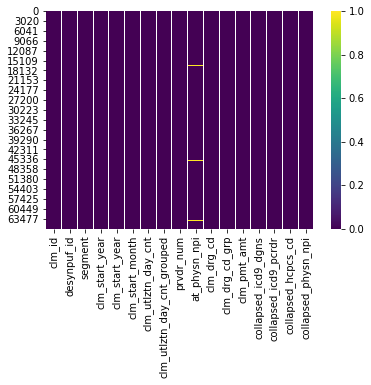

In [29]:
sns.heatmap(model_df.isnull(), cmap = 'viridis')
print(model_df.columns)
model_df.head()

(343858, 4)
(116395, 4)
        desynpuf_id bene_birth_dt bene_sex_ident_cd bene_race_cd
0  00000B48BCF4AD29      19230901                 2            5
1  0000525AB30E4DEF      19201001                 2            1
2  00009C897C3D8372      19320101                 1            1
3  0001168CE43BE51B      19340901                 2            1
4  0002E494BC87CE10      19140701                 1            2


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (116395, 19)
DE1_0_2008_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 22)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (114618, 19)
DE1_0_2009_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 40)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP JOINER SHAPE (112845, 19)
DE1_0_2010_BENEFICIARY_SUMMARY_FILE_SAMPLE_2.ZIP NEW K SHAPE (116395, 58)
df shape - model df (66434, 74)
k shape - shape of keys df (116395, 58)
df head - model df            clm_id       desynpuf_id  segment  clm_start_year  clm_start_year  \
0  45461150060934  00000B48BCF4AD29        1            2008            2008   
1  45541150055035  00000B48BCF4AD29        1            2008            2008   
2  45731150068478  00000B48BCF4AD29        1            2008            2008   
3  45811150057351  0000525AB30E4DEF        1            2008            2008   
4  45391150058019  0000525AB30E4DEF        1            2008  

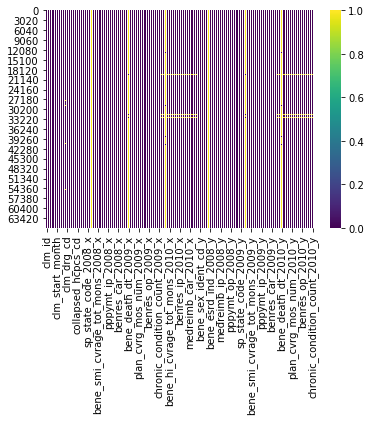

In [74]:
model_df = add_summary_info(summary_file_list, model_df)
sns.heatmap(model_df.isnull(), cmap = 'viridis')

In [75]:
for m in model_df.dtypes.index[model_df.dtypes == 'object']:
    if m not in ['desynpuf_id', 'bene_birth_dt','prvdr_num','clm_drg_cd','collapsed_icd9_dgns','collapsed_icd9_pcrdr','collapsed_physn_npi']:
        print(m)
        print(model_df[m].value_counts())

clm_utlztn_day_cnt_grouped
0-3 days       30602
4-7 days       22157
Over 7 days    13675
Name: clm_utlztn_day_cnt_grouped, dtype: int64
clm_drg_cd_grp
Other    27515
176        279
887        266
175        265
187        264
886        263
884        259
949        257
181        255
163        253
177        252
183        251
947        250
180        248
941        248
184        246
876        246
206        245
168        244
182        244
885        242
203        240
202        239
882        237
166        237
199        236
883        235
200        234
881        233
196        233
         ...  
658        109
334        109
698        108
387        108
672        108
556        108
380        108
348        107
345        106
379        106
355        106
653        105
329        105
671        105
374        105
668        104
684        104
623        104
372        104
388        104
669        104
357        103
656        103
354        102
666        102
697     

In [76]:
c = model_df.dtypes.index[model_df.dtypes != 'object'].sort_values()
yoy_cols = [st for st in c if re.findall('\d{4}', st) != []]
other_num_cols = [st for st in c if re.findall('\d{4}', st) == []]

In [77]:
## groups year columns together so we can see changes over time
n = 0
while n < len(yoy_cols):
    cols = yoy_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       bene_county_cd_2008_x  bene_county_cd_2008_y  bene_county_cd_2009_x
count           66434.000000           66434.000000           66250.000000
mean              378.347352             378.347352             378.329947
std               267.952670             267.952670             267.894280
min                 0.000000               0.000000               0.000000
25%               150.000000             150.000000             150.000000
50%               341.000000             341.000000             341.000000
75%               570.000000             570.000000             570.000000
max               999.000000             999.000000             999.000000
       bene_county_cd_2009_y  bene_county_cd_2010_x  bene_county_cd_2010_y
count           66250.000000           65678.000000           65678.000000
mean              378.329947             378.200630             378.200630
std               267.894280             267.815066             267.815066
min                 0.000

       benres_op_2009_y  benres_op_2010_x  benres_op_2010_y
count      66250.000000      65678.000000      65678.000000
mean         535.443623        283.932519        283.932519
std          930.969802        621.961670        621.961670
min            0.000000          0.000000          0.000000
25%           40.000000          0.000000          0.000000
50%          220.000000         50.000000         50.000000
75%          630.000000        290.000000        290.000000
max        12400.000000       9670.000000       9670.000000
       chronic_condition_count_2008_x  chronic_condition_count_2008_y  \
count                    66434.000000                    66434.000000   
mean                         6.059909                        6.059909   
std                          2.600904                        2.600904   
min                          0.000000                        0.000000   
25%                          4.000000                        4.000000   
50%                   

max        68000.000000      68000.000000      68000.000000
       pppymt_op_2008_x  pppymt_op_2008_y  pppymt_op_2009_x
count      66434.000000      66434.000000      66250.000000
mean          53.983954         53.983954         57.342038
std          521.567485        521.567485        576.136758
min            0.000000          0.000000          0.000000
25%            0.000000          0.000000          0.000000
50%            0.000000          0.000000          0.000000
75%            0.000000          0.000000          0.000000
max        14020.000000      14020.000000      14500.000000
       pppymt_op_2009_y  pppymt_op_2010_x  pppymt_op_2010_y
count      66250.000000      65678.000000      65678.000000
mean          57.342038         29.199123         29.199123
std          576.136758        401.421536        401.421536
min            0.000000          0.000000          0.000000
25%            0.000000          0.000000          0.000000
50%            0.000000          0.00000

In [78]:
n = 0
while n < len(other_num_cols):
    cols = other_num_cols[n:(n+3)]
    print(model_df.loc[:,cols].describe())
    n = n + 3

       at_physn_npi        clm_id   clm_pmt_amt
count  6.582200e+04  6.643400e+04  66434.000000
mean   5.057975e+09  4.549849e+13   9523.033838
std    2.914929e+09  2.847276e+11   9184.010360
min    2.977760e+05  4.501115e+13 -10000.000000
25%    2.482526e+09  4.525115e+13   4000.000000
50%    4.986923e+09  4.550115e+13   7000.000000
75%    7.668307e+09  4.574115e+13  11000.000000
max    9.999956e+09  4.599115e+13  57000.000000
       clm_start_month  clm_start_year  clm_start_year  clm_start_year  \
count     66434.000000    66434.000000    66434.000000    66434.000000   
mean          6.277554     2008.784086     2008.784086     2008.784086   
std           3.356556        0.763096        0.763096        0.763096   
min           1.000000     2007.000000     2007.000000     2007.000000   
25%           3.000000     2008.000000     2008.000000     2008.000000   
50%           6.000000     2009.000000     2009.000000     2009.000000   
75%           9.000000     2009.000000     2009.00

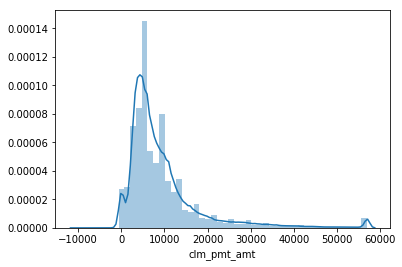

In [66]:
sns.distplot(model_df.clm_pmt_amt)

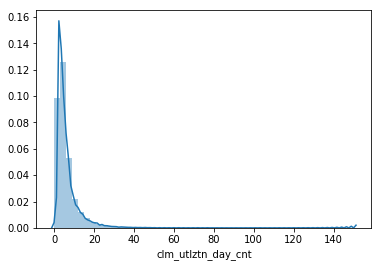

In [67]:
sns.distplot(model_df.clm_utlztn_day_cnt)

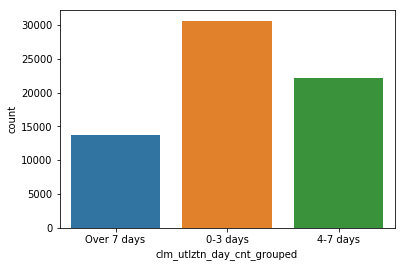

In [68]:
sns.countplot(model_df.clm_utlztn_day_cnt_grouped)

In [69]:
model_df.columns

Index(['clm_id', 'desynpuf_id', 'segment', 'clm_start_year', 'clm_start_year',
       'clm_start_month', 'clm_utlztn_day_cnt', 'clm_utlztn_day_cnt_grouped',
       'prvdr_num', 'at_physn_npi', 'clm_drg_cd', 'clm_drg_cd_grp',
       'clm_pmt_amt', 'collapsed_icd9_dgns', 'collapsed_icd9_pcrdr',
       'collapsed_hcpcs_cd', 'collapsed_physn_npi', 'bene_birth_dt',
       'bene_sex_ident_cd', 'bene_race_cd', 'sp_state_code_2008',
       'bene_county_cd_2008', 'bene_death_dt_2008', 'bene_esrd_ind_2008',
       'bene_hi_cvrage_tot_mons_2008', 'bene_smi_cvrage_tot_mons_2008',
       'bene_hmo_cvrage_tot_mons_2008', 'plan_cvrg_mos_num_2008',
       'medreimb_ip_2008', 'benres_ip_2008', 'pppymt_ip_2008',
       'medreimb_op_2008', 'benres_op_2008', 'pppymt_op_2008',
       'medreimb_car_2008', 'benres_car_2008', 'pppymt_car_2008',
       'chronic_condition_count_2008', 'sp_state_code_2009',
       'bene_county_cd_2009', 'bene_death_dt_2009', 'bene_esrd_ind_2009',
       'bene_hi_cvrage_tot_mons_

In [70]:
model_df.head()

,clm_id,desynpuf_id,segment,clm_start_year,clm_start_year,clm_start_month,clm_utlztn_day_cnt,clm_utlztn_day_cnt_grouped,prvdr_num,at_physn_npi,...,medreimb_ip_2010,benres_ip_2010,pppymt_ip_2010,medreimb_op_2010,benres_op_2010,pppymt_op_2010,medreimb_car_2010,benres_car_2010,pppymt_car_2010,chronic_condition_count_2010
0,45461150060934,00000B48BCF4AD29,1,2008,2008,7,11.0,Over 7 days,1000GD,1.219278e+09,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
1,45541150055035,00000B48BCF4AD29,1,2008,2008,7,2.0,0-3 days,1030RD,9.812675e+09,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
2,45731150068478,00000B48BCF4AD29,1,2008,2008,8,15.0,Over 7 days,1001NA,6.035410e+09,...,0.0,0.0,0.0,600.0,30.0,0.0,3800.0,1460.0,0.0,8.0
3,45811150057351,0000525AB30E4DEF,1,2008,2008,5,11.0,Over 7 days,3900MB,1.511429e+09,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0
4,45391150058019,0000525AB30E4DEF,1,2008,2008,9,6.0,4-7 days,3100JN,3.198318e+09,...,0.0,0.0,0.0,240.0,190.0,0.0,440.0,60.0,0.0,10.0


In [80]:
#merged_df.reindex(list(range(1,len(model_df['desynpuf_id']))))
print(model_df.index)
print(model_df.index.unique())

Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            66424, 66425, 66426, 66427, 66428, 66429, 66430, 66431, 66432,
            66433],
           dtype='int64', length=66434)
Int64Index([    0,     1,     2,     3,     4,     5,     6,     7,     8,
                9,
            ...
            66424, 66425, 66426, 66427, 66428, 66429, 66430, 66431, 66432,
            66433],
           dtype='int64', length=66434)


In [71]:
print(model_df.groupby('clm_utlztn_day_cnt_grouped')['clm_utlztn_day_cnt','clm_pmt_amt'].mean())
sns.catplot(x = 'clm_pmt_amt',
            y = 'clm_utlztn_day_cnt_grouped',
            kind = 'violin', #inner = 'stick',
           data = model_df)

sns.catplot(x = 'clm_utlztn_day_cnt',
            y = 'clm_utlztn_day_cnt_grouped',
             kind = 'violin', #inner = 'stick',
           data = model_df)

ValueError: cannot reindex from a duplicate axis